<h1 style="text-align: center;"><b>Линейная, LASSO, Ridge регрессии и их оптимизация.</b></h1>

Сегодня мы поработаем с оптимизацией в линейных алгоритмах (линейная регрессия и логистическая регрессия), а также разберем способы регуляризации данных методов.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso, Ridge

# 1. Линейная регрессия

Линейные методы предполагают, что между признаками объекта (features) и целевой переменной (target/label) существует линейная зависимость, то есть
$$y = w_1 x_1 + w_2 x_2 + ... + w_k x_k + b, $$ где $у$ --- целевая переменная (что мы хотим предсказать), $x_i$ --- признак объекта $х$, $w_i$ --- вес $i$-го признака, $b$ --- bias (смещение, свободный член)

Часто предполагают, что объект $х$ содержит в себе фиктивный признак равный 1 для представления свободного члена $b$. В этом случае формула принимает простой вид:
$$y = \langle w, x \rangle,$$
где $\langle \cdot, \cdot \rangle$ -- скалярное произведение векторов $w, x \in \mathbb{R}^n$.

В матричной форме, в случае, когда у нас есть $m$ объектов формулу можно переписать следующим образом:
$$ Y = Xw, $$ где $Y$ -- столбец размера $n$, $X$ --- матрица признаков размера $n \times k$ (каждая строка матрицы есть описание признаков объекта), $w$ -- вектор весов размера $k$.

**Лосс (функция потерь):** 
$$
\begin{aligned}
L(y_{pred}, Y) &= \frac{1}{n}||y_{pred} - Y||^2_2 =\\
&= \frac{1}{n}||Xw - Y||^2_2 = \frac{1}{n}\sum_{i=1}^{n}\left(\sum_{j=1}^{m} x_{ij}w_j - y_i\right)^2 =: L(w)
\end{aligned}
$$

### 1.1 Аналитическое решение

Минимизация ошибки по методу наименьших квадратов дает решение: $$ w = (X^TX)^{-1}X^TY $$

Реализуем класс линейной регрессии с помощью этой формулы.

#### Тестирование
Сначала сгенерируем искусственные данные для теста моделей по формуле $ y = 6*x + 11 + \epsilon$

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [3]:
# по признакам сгенерируем значения таргетов с некоторым шумом

formula = lambda x: 6 * x + 11

objects_num = 100
X = np.linspace(-10, 10, objects_num)
y = formula(X) + np.random.randn(objects_num) * 12

# выделим половину объектов на тест
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

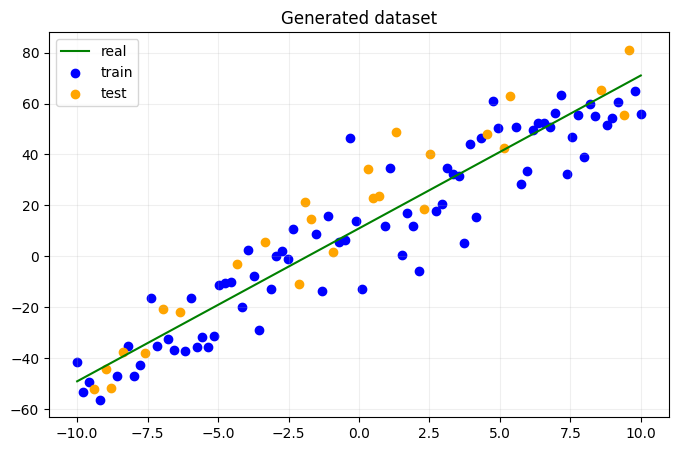

In [4]:
plt.figure(figsize=(8, 5))
plt.plot(X, formula(X), label='real', c='g')
plt.scatter(X_train, y_train, label='train', c='b')
plt.scatter(X_test, y_test, label='test', c='orange')

plt.title("Generated dataset")
plt.grid(alpha=0.2)
plt.legend()
plt.show()

In [8]:
# Обучим модель на трейне и предскажем результаты на тесте

model = LinearRegression()

model.fit(X_train.reshape(-1, 1), y_train)

y_pred = model.predict(X_test.reshape(-1, 1))

In [9]:
print(f"Predicted:\ny = {model.coef_[0]:.2f}x + {model.intercept_:.2f}")
print(f"Real:\ny = 6.00x + 11.00")

Predicted:
y = 5.76x + 8.40
Real:
y = 6.00x + 11.00


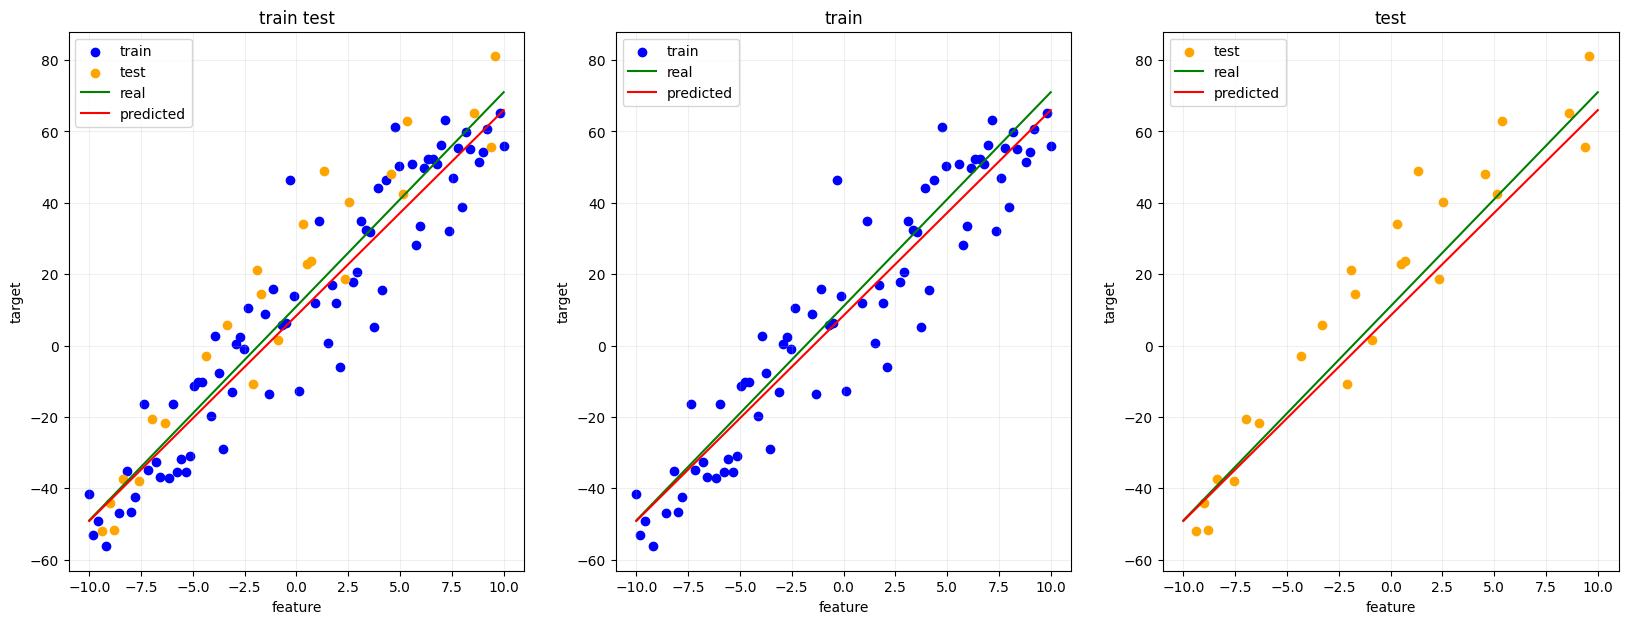

In [10]:
plt.figure(figsize=(20, 7))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')

    plt.plot(X, formula(X), label='real', c='g')
    plt.plot(X, model.predict(X[:, np.newaxis]), label='predicted', c='r')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()

In [11]:
from sklearn.metrics import mean_squared_error

train_predictions = model.predict(X_train[:, np.newaxis])
test_predictions = model.predict(X_test[:, np.newaxis])

print('Train MSE: ', mean_squared_error(y_train, train_predictions))
print('Test MSE: ', mean_squared_error(y_test, test_predictions))
print('Train RMSE: ', mean_squared_error(y_train, train_predictions) ** .5)
print('Test RMSE: ', mean_squared_error(y_test, test_predictions) ** .5)

Train MSE:  140.1617414953322
Test MSE:  202.00725346134888
Train RMSE:  11.838992418923672
Test RMSE:  14.212925577141002


In [9]:
pd.Series(y).describe()

count    100.000000
mean       9.563514
std       37.667483
min      -67.356713
25%      -18.731131
50%       11.212617
75%       39.690216
max       85.386214
dtype: float64

# 2. О регуляризации

Зачастую модель обучается на каких-то зашумленных данных. Веса модели после обучения подбираются для уменьшения ошибки целевой функции. От различных выборках модель может обучаться по-разному, но нам бы хотелось вычленять основную зависимость примерно одинаково, то есть **не переобучаться (overfit)** на данных. Иначе обучившись на одном сете, мы можем получать неожиданный результат на других данных.

То есть мы хотели бы штрафовать модель за ее сложность, чтобы выискивать более простые зависимости.


Еще одной проблемой, специфичной для линейных моделей, является **мультиколлинеарность**, т.е. ситуация, когда один признак является линейной комбинацией других. 

Из-за мультиколлинеарности могут получать очень большие коэффициенты. Отсюда вывод: необходимо каким-то образом ограничить величину коэффициентов модели.

Для линейной модели дополнительные ограничения на веса выполняют роль регуляризации. Различают:
- $l_1$-регуляризацию (LASSO, least absolute shrinkage and selection operator), учитывание $||w||_1$ 
- $l_2$-регуляризацию (Ridge), учитывание $||w||^2_2$
- Elastic net - комбинация двух предыдущих (учитываются обе нормы весов)

# 2.1 Ridge регрессия (l2 регуляризация)

В ridge мы штрафуем модель также на сумму квадратов всех ее весов, таким образом:

**Лосс:** $L(w) = ||Xw - Y||^2_2 + \lambda||w||^2_2$, где $\lambda$ - гиперпараметр, отвечающий за степень регуляризации.

В привычном понимании:

**Лосс:** $L(w) = \sum_{i=1}^n\left(\sum_{j=1}^{m} x_{ij}w_j - y_i\right)^2 + \lambda\sum_{j=1}^{m}w_j^2$


Что стоит сказать про значения признаков? Они должны быть стандартизованы для одинаковых штрафов относительно друг друга! (используется связка с `sklearn.preprocessing.StandardScaler`)

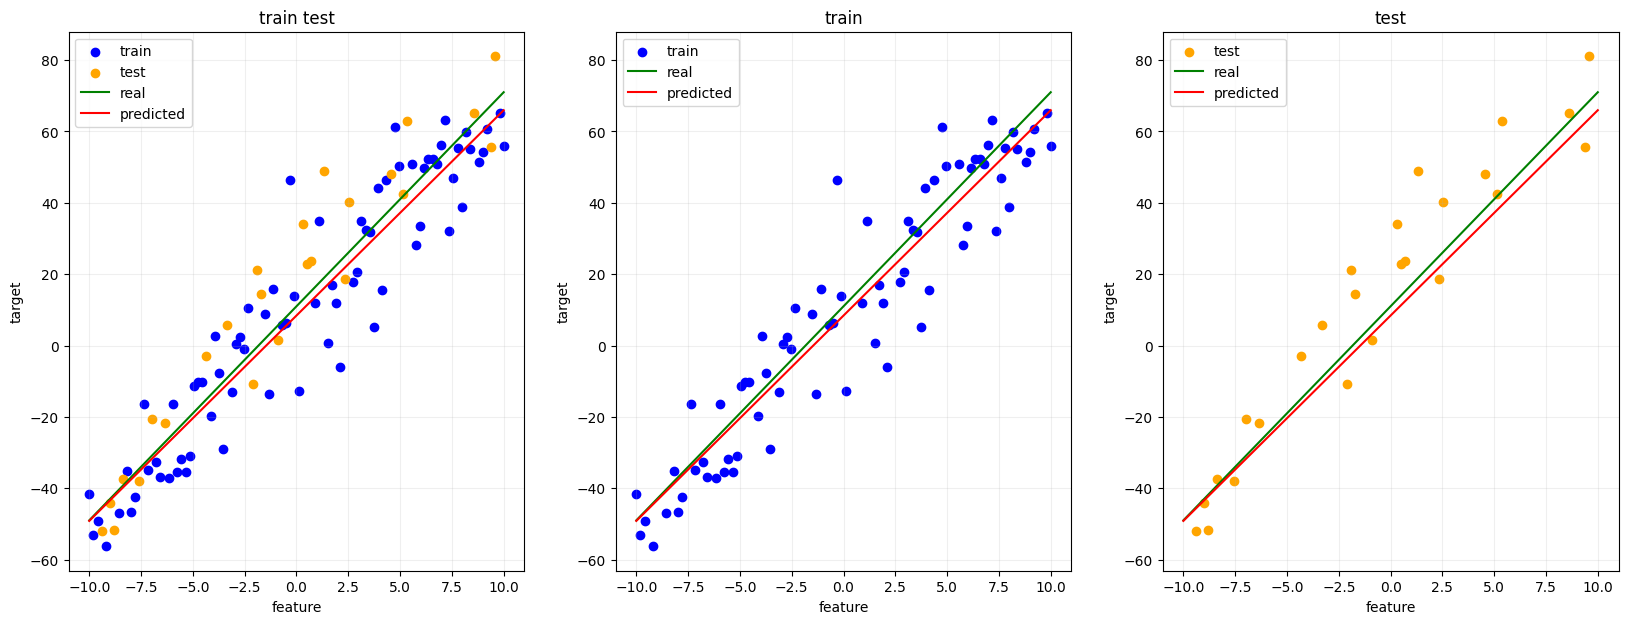

Predicted:
y = 5.76x + 8.40
Real:
y = 6.00x + 11.00
Train MSE:  140.1619149815534
Test MSE:  202.05752866267957
Train RMSE:  11.838999745821155
Test RMSE:  14.214694110767194


In [12]:
from sklearn.linear_model import Ridge

model = Ridge()

model.fit(X_train[:, np.newaxis], y_train)

y_pred = model.predict(X_test[:, np.newaxis])


plt.figure(figsize=(20, 7))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')

    plt.plot(X, formula(X), label='real', c='g')
    plt.plot(X, model.predict(X[:, np.newaxis]), label='predicted', c='r')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()

print(f"Predicted:\ny = {model.coef_[0]:.2f}x + {model.intercept_:.2f}")
print(f"Real:\ny = 6.00x + 11.00")
train_predictions = model.predict(X_train[:, np.newaxis])
test_predictions = model.predict(X_test[:, np.newaxis])

print('Train MSE: ', mean_squared_error(y_train, train_predictions))
print('Test MSE: ', mean_squared_error(y_test, test_predictions))
print('Train RMSE: ', mean_squared_error(y_train, train_predictions) ** .5)
print('Test RMSE: ', mean_squared_error(y_test, test_predictions) ** .5)


Решение получилось таким же, так как под капотом в sklearn в ridge регуляризации используется МНК, т.е. мы находим аналитическое решение через матрицы.

# 2.2 LASSO регрессия (l1 регуляризация)

В LASSO мы штрафуем модель также **на сумму модулей всех ее весов** (на l1-норму весов), таким образом:

**Лосс:** $L(w) = \frac{1}{2n} ||Xw - Y||^2_2 + \lambda ||w||_1$, где $\lambda$ - гиперпараметр, отвечающий за степень регуляризации.

В привычном понимании:

**Лосс:** $L(w) = \frac{1}{2n}\sum_{i=1}^n\left(\sum_{j=1}^{m} x_{ij}w_j - y_i\right)^2 + \lambda\sum_{j=1}^{m}|w_j|$

Признаки опять же должны быть стандартизованы для одинаковых штрафов относительно друг друга!

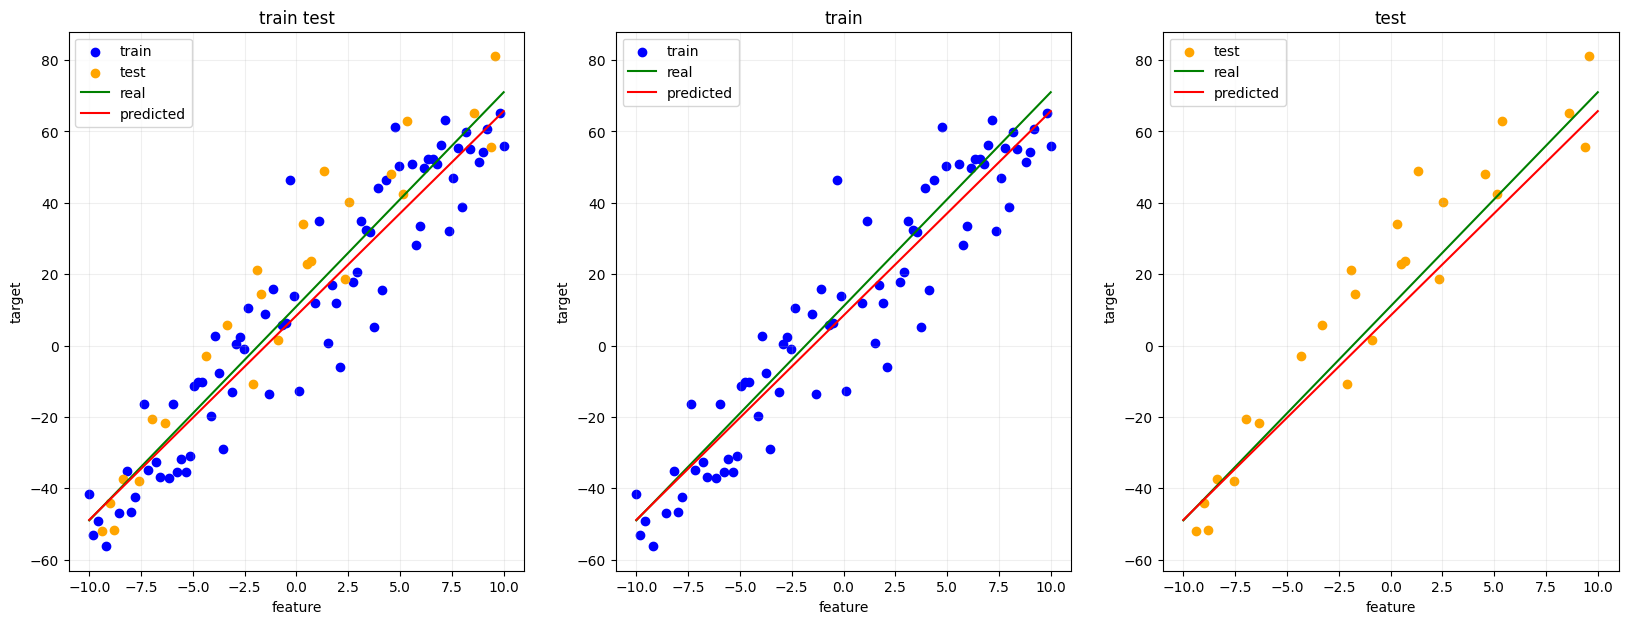

Predicted:
y = 5.73x + 8.41
Real:
y = 6.00x + 11.00
Train MSE:  140.1912013473474
Test MSE:  202.6900353814504
Train RMSE:  11.84023654102178
Test RMSE:  14.236925067634878


In [17]:
from sklearn.linear_model import Lasso

model = Lasso()

model.fit(X_train[:, np.newaxis], y_train)

y_pred = model.predict(X_test[:, np.newaxis])


plt.figure(figsize=(20, 7))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')

    plt.plot(X, formula(X), label='real', c='g')
    plt.plot(X, model.predict(X[:, np.newaxis]), label='predicted', c='r')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()

print(f"Predicted:\ny = {model.coef_[0]:.2f}x + {model.intercept_:.2f}")
print(f"Real:\ny = 6.00x + 11.00")
train_predictions = model.predict(X_train[:, np.newaxis])
test_predictions = model.predict(X_test[:, np.newaxis])

print('Train MSE: ', mean_squared_error(y_train, train_predictions))
print('Test MSE: ', mean_squared_error(y_test, test_predictions))
print('Train RMSE: ', mean_squared_error(y_train, train_predictions) ** .5)
print('Test RMSE: ', mean_squared_error(y_test, test_predictions) ** .5)

Здесь можем наблюдать различия, так как теперь решение находится не через МНК, а стохастически.

# 2.3 Различия LASSO и Ridge

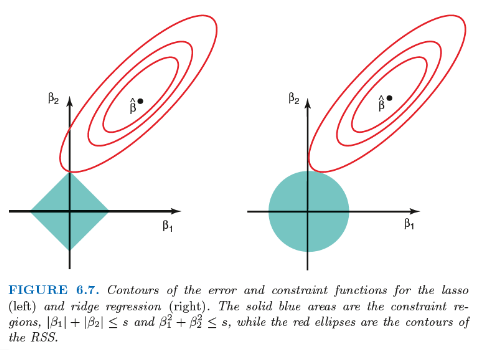

Различий несколько между $l_1$ и $l_2$ регуляризациями:

- Lasso **сложнее считать** из-за недифференцируемых углов шара в $l_1$ норме (в значении нуля для признаков)
- **отсутствие аналитического решения** делает вычисления и теоретические значения весов при $l_1$ регуляризации более сложными
- В Lasso появляется **зануление весов** для некоторых признаков

### 3. Градиентная оптимизация

Обращение матрицы -- очень долгая операция. Кроме того, обратная матрица $(X^TX)^{-1}$ не всегда существует. По этим причинам, мы воспользуемся методом градиентного спуска для оптимизации эмпирического риска.

Градиентый спуск заключается в 
1. расчете $\displaystyle\frac{\partial{L}}{\partial{w}}$ -- градиента ошибки (значение целевой функции, то есть лосса $L(y_{pred}, y_{true})$) от значения параметров модели (весов $w$)
2. шаге спуска -- изменении весов $w$ в сторону антиградиента с некоторым коэффициентом $h$ (он же learning rate):
$$w := w - h\frac{\partial{L}}{\partial{w}}$$
3. Повторении п.1 и п.2 пока не наблюдается сходимость (изменения ошибки малы или отсутсвуют)

Как правило, чаще используют стохастический градиентный спуск (SGD): выбирают случайный элемент обучающей выборки и изменяют коэффициенты модели по направлению антиградиента функции потерь на этом примере.

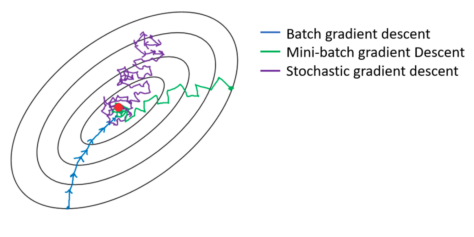

**Цель:** Реализуем новые классы линейной регрессии, в которой оптимизация проводится методами градиентного спуска.

**Предполагаемая зависимость:** $Y = Xw$, где $Y \in \mathbb{R}^{n\times 1}, X \in \mathbb{R}^{n\times m}, w \in \mathbb{R}^{m\times 1}$


**Минимизируемая функция:**
$$
L(y_{pred}, Y) = \frac{1}{n} ||y_{pred} - Y||^2 = \frac{1}{n}||Xw - Y||^2 = \frac{1}{n}(Xw - Y)^T(Xw - Y) = \frac{1}{n}(w^TX^TXw - 2Y^TXw + Y^TY)
$$

**Градиент w.r.t. $w$:**
$$
\frac{\partial{L}}{\partial{w}} = \frac{2}{n}(X^TXw - X^TY) = \frac{2}{n}X^T(y_{pred} - Y) \,\, \in \mathbb{R}^{m \times 1}
$$

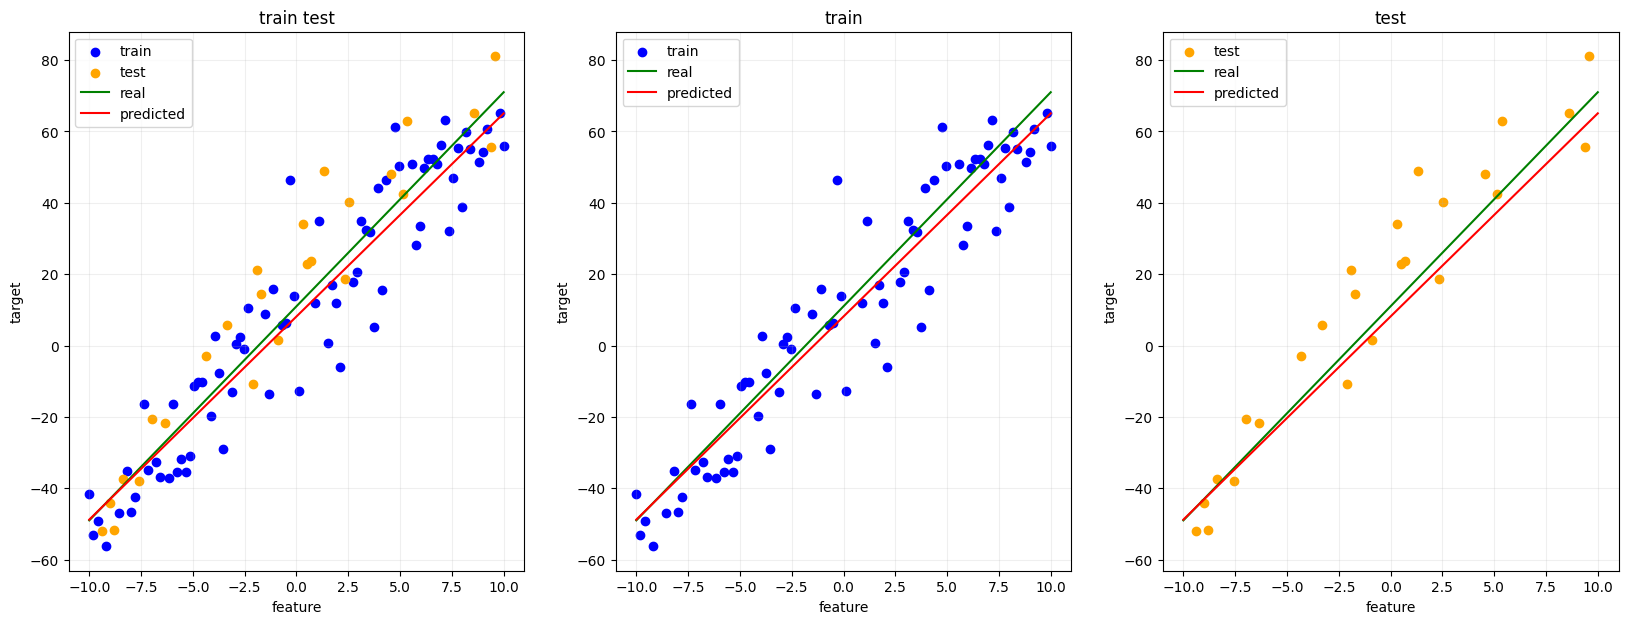

Predicted:
y = 5.69x + 8.14
Real:
y = 6.00x + 11.00
Train MSE:  140.3774825460705
Test MSE:  208.38757515785267
Train RMSE:  11.848100377109846
Test RMSE:  14.435635599371878


In [35]:
from sklearn.linear_model import SGDRegressor

model = SGDRegressor(penalty='elasticnet', l1_ratio=0.1)

model.fit(X_train[:, np.newaxis], y_train)

y_pred = model.predict(X_test[:, np.newaxis])


plt.figure(figsize=(20, 7))

ax = None

for i, types in enumerate([['train', 'test'], ['train'], ['test']]):
    ax = plt.subplot(1, 3, i + 1, sharey=ax)
    if 'train' in types:
        plt.scatter(X_train, y_train, label='train', c='b')
    if 'test' in types:
        plt.scatter(X_test, y_test, label='test', c='orange')

    plt.plot(X, formula(X), label='real', c='g')
    plt.plot(X, model.predict(X[:, np.newaxis]), label='predicted', c='r')

    plt.ylabel('target')
    plt.xlabel('feature')
    plt.title(" ".join(types))
    plt.grid(alpha=0.2)
    plt.legend()

plt.show()

print(f"Predicted:\ny = {model.coef_[0]:.2f}x + {model.intercept_[0]:.2f}")
print(f"Real:\ny = 6.00x + 11.00")
train_predictions = model.predict(X_train[:, np.newaxis])
test_predictions = model.predict(X_test[:, np.newaxis])

print('Train MSE: ', mean_squared_error(y_train, train_predictions))
print('Test MSE: ', mean_squared_error(y_test, test_predictions))
print('Train RMSE: ', mean_squared_error(y_train, train_predictions) ** .5)
print('Test RMSE: ', mean_squared_error(y_test, test_predictions) ** .5)

# Практика

In [36]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split


In [37]:
df = pd.read_csv("./Data/insurance.csv")
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [78]:
df.charges.mean()

13270.422265141257

1. Сохраните в отдельную переменную числовые столбцы, в другую -- целевой столбец
2. Разбейте данные на трейн и тест. В тест отправьте 20% данных. Используйте random_state=23122023
3. Обучите модель линейной регрессии (простая LinearRegression без регуляризации). Признаки не шкалируйте.
4. Получите предсказания для теста
5. Посчитайте RMSE (импортируйте mean_square_error из sklearn.metrics, посчитайте MSE, найдите корень из MSE)
<br><br>
6. Теперь закодируйте категории и повторите шаги 3,4,5

#### 1.

In [38]:
num_cols = ['age', 'bmi', 'children']
X = df[num_cols]
y = df['charges']

#### 2.

In [73]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23122023 ) 

#### 3.

In [74]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

#### 4.

In [75]:
y_pred = model.predict(X_test)

#### 5.

In [76]:
from sklearn.metrics import mean_squared_error, r2_score
mean_squared_error(y_test, y_pred) ** 0.5

11730.593507602187

In [77]:
r2_score(y_test, y_pred)

0.03663194501134659

In [52]:
11131.719807141493 == 11730.593507602187

False

In [39]:
mean_squared_error(y_test, y_pred) ** 0.5

11730.593507602187

In [40]:
r2_score(y_test, y_pred)

0.03663194501134659

#### 6.

### label encoding

#### pandas

In [83]:
df['sex_encoded'] = (df['sex'] == 'male').astype(int)
df.head()

,age,sex,bmi,children,smoker,region,charges,sex_encoded
0,19,female,27.900,0,yes,southwest,16884.92400,0
1,18,male,33.770,1,no,southeast,1725.55230,1
2,28,male,33.000,3,no,southeast,4449.46200,1
3,33,male,22.705,0,no,northwest,21984.47061,1
4,32,male,28.880,0,no,northwest,3866.85520,1


In [85]:
df['sex_encoded'] = df['sex'].map(
    {'male': 0, 'female':1}
)
df.head()

,age,sex,bmi,children,smoker,region,charges,sex_encoded
0,19,female,27.900,0,yes,southwest,16884.92400,1
1,18,male,33.770,1,no,southeast,1725.55230,0
2,28,male,33.000,3,no,southeast,4449.46200,0
3,33,male,22.705,0,no,northwest,21984.47061,0
4,32,male,28.880,0,no,northwest,3866.85520,0


#### LabelEncoder

In [95]:
from sklearn import set_config
set_config(transform_output='pandas')

In [96]:
from sklearn.preprocessing import LabelEncoder

In [97]:
encoder = LabelEncoder()
encoder.fit(df['sex'])

LabelEncoder()

In [99]:
df['sex_encoded_sklearn'] = encoder.transform(df['sex'])

In [101]:
df.head()

,age,sex,bmi,children,smoker,region,charges,sex_encoded,sex_encoded_sklearn
0,19,female,27.900,0,yes,southwest,16884.92400,1,0
1,18,male,33.770,1,no,southeast,1725.55230,0,1
2,28,male,33.000,3,no,southeast,4449.46200,0,1
3,33,male,22.705,0,no,northwest,21984.47061,0,1
4,32,male,28.880,0,no,northwest,3866.85520,0,1


### OneHot encoding

In [102]:
df['region'].nunique()

4

In [103]:
df['region'].value_counts()

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64

#### Pandas

In [121]:
pd.get_dummies(df[['region', 'sex']], drop_first=True).astype(int)

,region_northwest,region_southeast,region_southwest,sex_male
0,0,0,1,0
1,0,1,0,1
2,0,1,0,1
3,1,0,0,1
4,1,0,0,1
...,...,...,...,...
1333,1,0,0,1
1334,0,0,0,0
1335,0,1,0,0
1336,0,0,1,0


#### sklearn one-hot encoder

In [111]:
from sklearn.preprocessing import OneHotEncoder

In [117]:
encoder = OneHotEncoder(drop='first', sparse_output=False)

In [120]:
encoder.fit_transform(df[['sex', 'smoker', 'region']])

,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
1333,1.0,0.0,1.0,0.0,0.0
1334,0.0,0.0,0.0,0.0,0.0
1335,0.0,0.0,0.0,1.0,0.0
1336,0.0,0.0,0.0,0.0,1.0



1. Попробуйте построить обычную линейную регрессию только на числовых признаках. Посчитайте RMSE.

In [130]:
num_cols = ['age', 'bmi', 'children']
cat_cols = ['sex', 'smoker', 'region']
X_num = df[num_cols]
X_cat = pd.get_dummies(df[cat_cols], drop_first=True).astype(np.int8)
X = pd.concat([X_num, X_cat], axis=1)
y = df['charges']

In [135]:
X.head()

,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,0,1,0,0,1
1,18,33.770,1,1,0,0,1,0
2,28,33.000,3,1,0,0,1,0
3,33,22.705,0,1,0,1,0,0
4,32,28.880,0,1,0,1,0,0


In [136]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23122023) 

2. Закодируйте столбцы `sex` и `smoker` с помощью LabelEncoder , а region -- с помощью OneHotEncoder (или pd.get_dummies). Обучите заново модель и посчитайте RMSE.

In [137]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [138]:
mean_squared_error(y_test, y_pred) ** 0.5

6002.9394726934115

In [142]:
df['charges'].agg(['mean', 'std']).round()

mean    13270.0
std     12110.0
Name: charges, dtype: float64

In [139]:
r2_score(y_test, y_pred)

0.7477215241707278

In [144]:
model.feature_names_in_

array(['age', 'bmi', 'children', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype=object)

In [143]:
model.coef_

array([  259.64875473,   348.58784183,   530.33663126,  -282.5043352 ,
       23978.1142726 ,  -341.27863992, -1223.6633018 , -1172.8488516 ])

In [148]:
coefs = pd.DataFrame({'feature': model.feature_names_in_, 'coef': model.coef_})
coefs = coefs.sort_values(by='coef', ascending=False)
coefs

,feature,coef
4,smoker_yes,23978.114273
2,children,530.336631
1,bmi,348.587842
0,age,259.648755
3,sex_male,-282.504335
5,region_northwest,-341.278640
7,region_southwest,-1172.848852
6,region_southeast,-1223.663302


<Axes: xlabel='coef', ylabel='feature'>

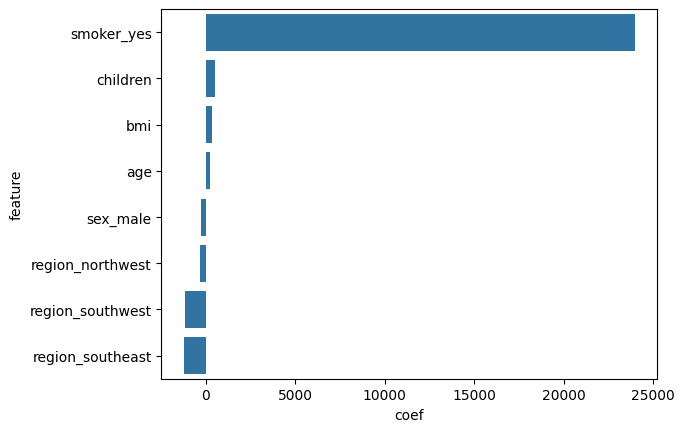

In [149]:
sns.barplot(data=coefs, y='feature', x='coef', orient='h')

In [150]:
from sklearn.preprocessing import StandardScaler

In [151]:
model = LinearRegression()
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [152]:
mean_squared_error(y_test, y_pred) ** 0.5

6002.9394726934115

In [153]:
r2_score(y_test, y_pred)

0.7477215241707278

In [154]:
coefs = pd.DataFrame({'feature': model.feature_names_in_, 'coef': model.coef_})
coefs = coefs.sort_values(by='coef', ascending=False)
coefs

,feature,coef
4,smoker_yes,9506.178539
0,age,3647.550167
1,bmi,2152.053213
2,children,641.763388
3,sex_male,-141.210461
5,region_northwest,-146.370822
7,region_southwest,-503.677770
6,region_southeast,-544.494354


<Axes: xlabel='coef', ylabel='feature'>

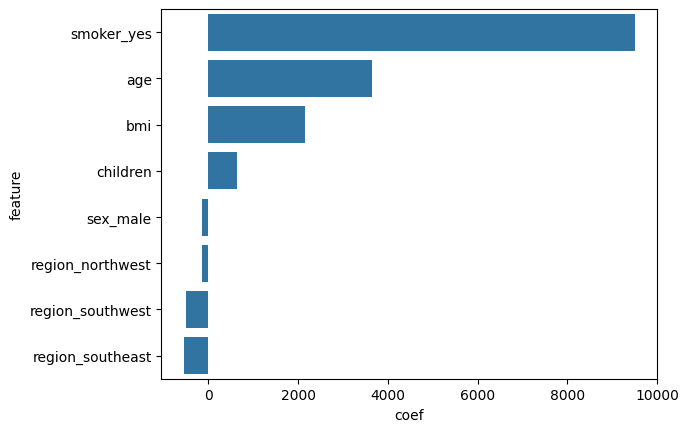

In [157]:
sns.barplot(data=coefs, y='feature', x='coef', orient='h')

3. *Сгенерируйте полиномимальный признак (добавьте в модель возраст в квадрате и возраст умноженный на статус курения), переобучите модель, посчитайте RMSE.

In [262]:
num_cols = ['age', 'bmi', 'children']
cat_cols = ['sex', 'smoker', 'region']
X_num = df[num_cols]
# руками
#for i in range(2, 3):
#    X_num[f"age^{i}"] = X_num['age'] ** i

X_cat = pd.get_dummies(df[cat_cols], drop_first=True).astype(np.int8)
X = pd.concat([X_num, X_cat], axis=1)
y = df['charges']

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23122023) 

In [264]:
#model = LinearRegression()
model = Ridge()
# model = Lasso(alpha=10)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [265]:
mean_squared_error(y_test, y_pred) ** 0.5

6002.251525411291

In [266]:
r2_score(y_test, y_pred)

0.7477793439597702

In [267]:
coefs = pd.DataFrame({'feature': model.feature_names_in_, 'coef': model.coef_})
coefs = coefs.sort_values(by='coef', ascending=False)
coefs

,feature,coef
4,smoker_yes,9497.180677
0,age,3644.407713
1,bmi,2149.878388
2,children,641.496078
3,sex_male,-140.290792
5,region_northwest,-145.804032
7,region_southwest,-502.625864
6,region_southeast,-542.229821


<Axes: >

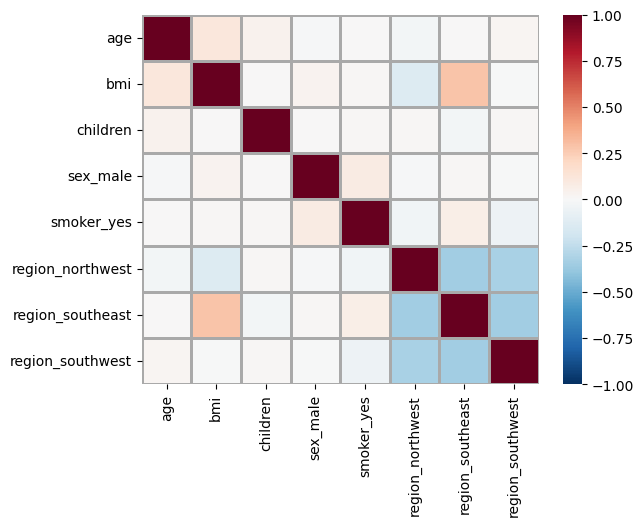

In [268]:
sns.heatmap(X_train.corr(), vmin=-1, vmax=1, cmap='RdBu_r', linewidth=1, linecolor='darkgray')

In [269]:
import statsmodels.api as sm

In [270]:
X_train['const'] = 1
X_test['const'] = 1

model = sm.OLS(y_train, X_train)

res = model.fit()
y_pred = res.predict(X_test)

In [271]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     400.6
Date:                Sat, 25 May 2024   Prob (F-statistic):          2.90e-314
Time:                        14:15:04   Log-Likelihood:                -10836.
No. Observations:                1070   AIC:                         2.169e+04
Df Residuals:                    1061   BIC:                         2.174e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
age               3647.5502    187.322     19.472      0.000    3279.987    4015.113
bmi               2152.0532    196.576     10.948      0.000    1766.332    2537.775
children           641.7634    186.144      3.448      0.001     276.511    1007.016
sex_male          -141.2105    186.648     -0.757      0.449    -507.451     225.030
smoker_yes        9506.1785    187.136     50.798      0.000    9138.980    9873.377
region_northwest  -146.3708    229.335     -0.638      0.523    -596.373     303.632
region_southeast  -544.4944    240.562     -2.263      0.024   -1016.526     -72.463
region_southwest  -503.6778    230.498     -2.185      0.029    -955.961     -51.394
const             1.312e+04    185.859     70.568      0.000    1.28e+04    1.35e+04
==============================================================================
Omnibus:                      266.066   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              696.883
Skew:                           1.287   Prob(JB):                    4.72e-152
Kurtosis:                       6.000   Cond. No.                         2.24
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [272]:
mean_squared_error(y_test, y_pred) ** 0.5

6002.939472693412

In [273]:
r2_score(y_test, y_pred)

0.7477215241707278

In [274]:
from sklearn.preprocessing import PolynomialFeatures

In [280]:
PolynomialFeatures(degree=3).fit_transform(df[['age']])

,1,age,age^2,age^3
0,1.0,19.0,361.0,6859.0
1,1.0,18.0,324.0,5832.0
2,1.0,28.0,784.0,21952.0
3,1.0,33.0,1089.0,35937.0
4,1.0,32.0,1024.0,32768.0
...,...,...,...,...
1333,1.0,50.0,2500.0,125000.0
1334,1.0,18.0,324.0,5832.0
1335,1.0,18.0,324.0,5832.0
1336,1.0,21.0,441.0,9261.0


In [279]:
PolynomialFeatures(degree=3).fit_transform(df[['age', 'bmi']])

,1,age,bmi,age^2,age bmi,bmi^2,age^3,age^2 bmi,age bmi^2,bmi^3
0,1.0,19.0,27.900,361.0,530.100,778.410000,6859.0,10071.900,14789.790000,21717.639000
1,1.0,18.0,33.770,324.0,607.860,1140.412900,5832.0,10941.480,20527.432200,38511.743633
2,1.0,28.0,33.000,784.0,924.000,1089.000000,21952.0,25872.000,30492.000000,35937.000000
3,1.0,33.0,22.705,1089.0,749.265,515.517025,35937.0,24725.745,17012.061825,11704.814053
4,1.0,32.0,28.880,1024.0,924.160,834.054400,32768.0,29573.120,26689.740800,24087.491072
...,...,...,...,...,...,...,...,...,...,...
1333,1.0,50.0,30.970,2500.0,1548.500,959.140900,125000.0,77425.000,47957.045000,29704.593673
1334,1.0,18.0,31.920,324.0,574.560,1018.886400,5832.0,10342.080,18339.955200,32522.853888
1335,1.0,18.0,36.850,324.0,663.300,1357.922500,5832.0,11939.400,24442.605000,50039.444125
1336,1.0,21.0,25.800,441.0,541.800,665.640000,9261.0,11377.800,13978.440000,17173.512000
